## Document Classification: Tobacco3482

Dataset Source: https://www.kaggle.com/datasets/patrickaudriaz/tobacco3482jpg
(& subsequently: https://wiki.umiacs.umd.edu/clip/index.php/Main_Page)

#### Install Missing (& Necessary) Libraries

In [16]:
%pip install evaluate torch torchvision tqdm numpy datasets
%pip install transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Import Necessary Libraries

In [17]:
import os, sys

import numpy as np
from tqdm.notebook import tqdm

import PIL.Image

import transformers
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer

import datasets
from datasets import load_dataset, Features, Array3D, DatasetDict

import torch

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

import evaluate

!git lfs install

Git LFS initialized.


#### Display Versions of Relevant Languages & Libraries

In [18]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("evaluate:".rjust(15), evaluate.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.12
         NumPy: 1.24.2
      Datasets: 2.9.0
  Transformers: 4.26.1
      evaluate: 0.4.0
         Torch: 1.12.1


#### Ingest Dataset

In [19]:
dataset = load_dataset("data", drop_labels=False, split='train')

dataset

A Jupyter Widget

Using custom data configuration data-ad5944c1e30bdad1
Found cached dataset imagefolder (/Users/briandunn/.cache/huggingface/datasets/imagefolder/data-ad5944c1e30bdad1/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


Dataset({
    features: ['image', 'label'],
    num_rows: 6964
})

#### Split Dataset into Training & Evaluation Datasets

In [20]:
train_split = dataset.train_test_split(train_size=0.80)

ds = DatasetDict({
    'train' : train_split['train'],
    'eval' : train_split['test']
})

#### Show Some Information About Training & Testing Datasets

In [21]:
print("Training Dataset")
print(ds['train'])
print("Features: ", ds['train'].features)
print("First Entry:", ds['train'][0])
print("Last Entry:", ds['train'][-1])
print("Unique Label Values:", ds['train'].unique("label"))

print("\nEvaluation Dataset")
print(ds['eval'])
print("Features: ", ds['eval'].features)
print("First Entry:", ds['eval'][0])
print("Last Entry:", ds['eval'][-1])
print("Unique Label Values:", ds['eval'].unique("label"))

Training Dataset
Dataset({
    features: ['image', 'label'],
    num_rows: 5571
})
Features:  {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['ADVE', 'Email', 'Form', 'Letter', 'Memo', 'News', 'Note', 'Report', 'Resume', 'Scientific'], id=None)}
First Entry: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=2592x3488 at 0x7FC4B1EC9310>, 'label': 0}
Last Entry: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1728x2292 at 0x7FC4B21741C0>, 'label': 2}


A Jupyter Widget

Unique Label Values: [0, 1, 3, 4, 7, 2, 9, 5, 6, 8]

Evaluation Dataset
Dataset({
    features: ['image', 'label'],
    num_rows: 1393
})
Features:  {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['ADVE', 'Email', 'Form', 'Letter', 'Memo', 'News', 'Note', 'Report', 'Resume', 'Scientific'], id=None)}
First Entry: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=2480x3260 at 0x7FC4B21741C0>, 'label': 7}
Last Entry: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=2544x3464 at 0x7FC4B21742E0>, 'label': 0}


A Jupyter Widget

Unique Label Values: [7, 1, 6, 8, 2, 4, 3, 5, 0, 9]


#### Display Example Document

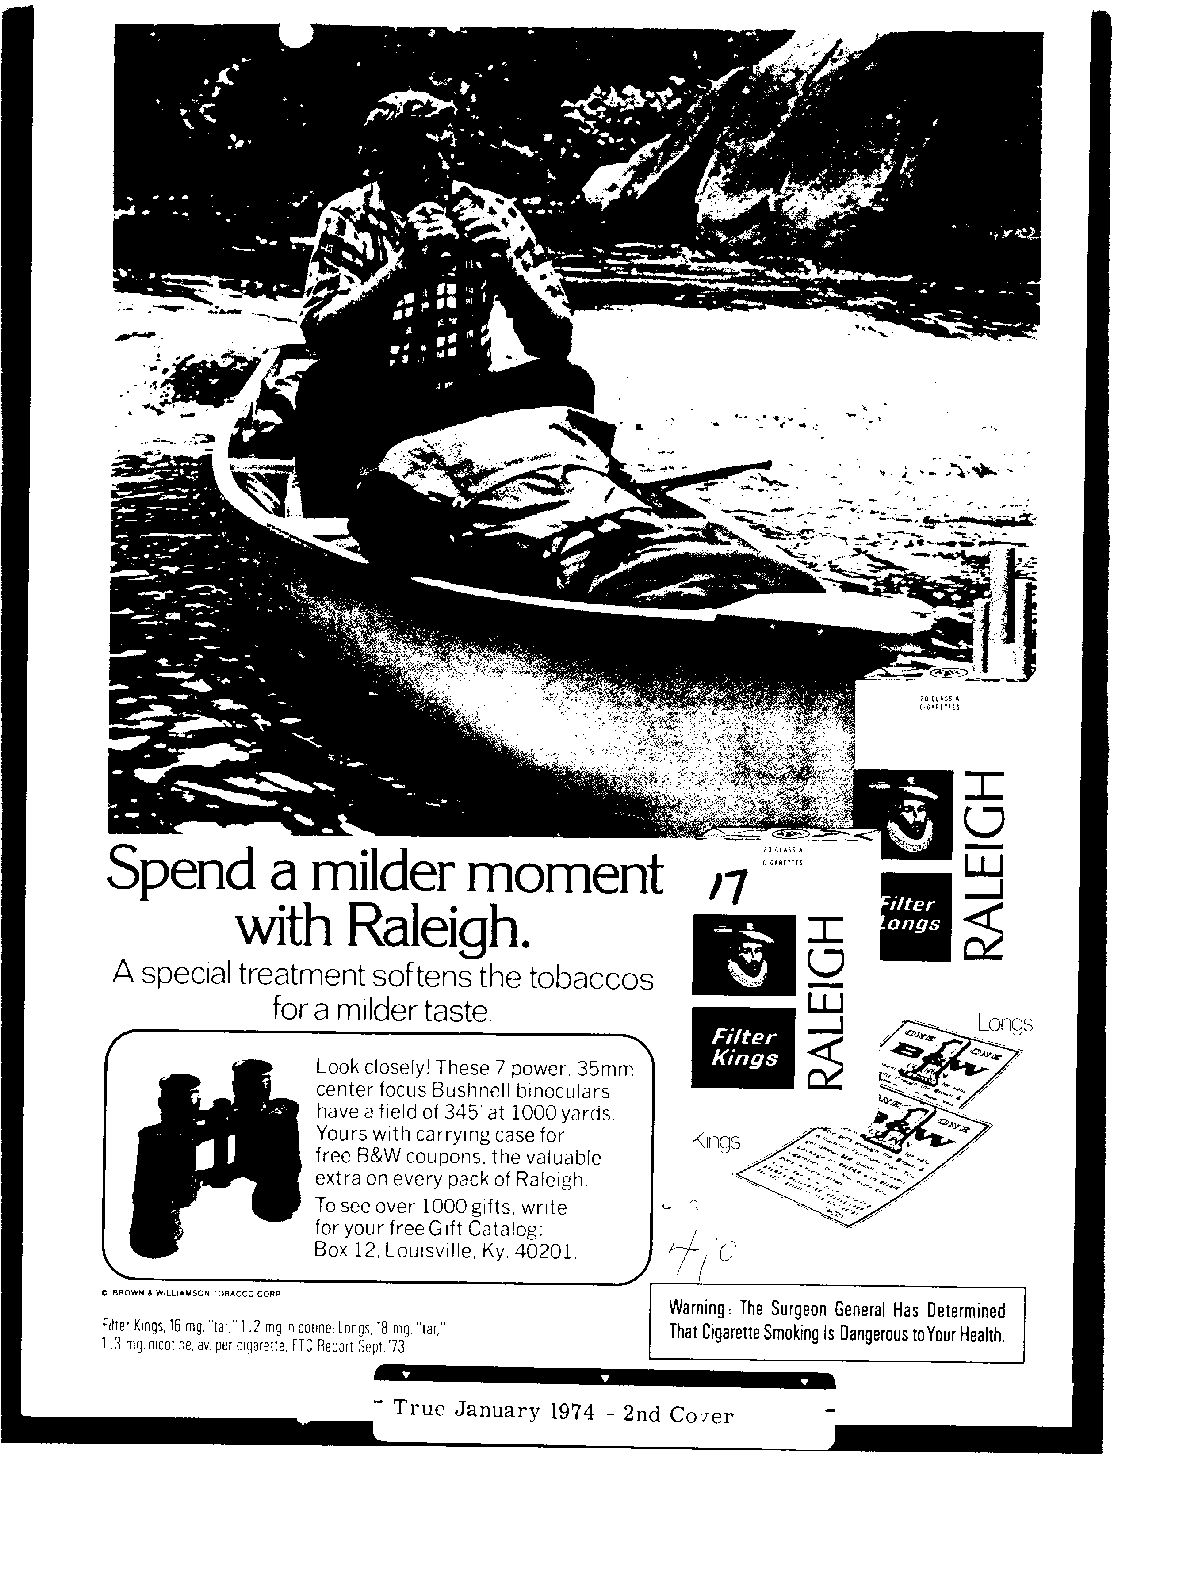

In [22]:
dataset[4]['image']

#### Show Class of Example

In [23]:
class_label_number = dataset[4]['label']
print(class_label_number)

0


#### Class Name for Example

In [24]:
labels = dataset.features['label'].names
print(labels[class_label_number])

ADVE


#### Converting Labels Between String & Integer Values

In [25]:
labels = dataset.features["label"].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(id2label)
print(label2id)

{0: 'ADVE', 1: 'Email', 2: 'Form', 3: 'Letter', 4: 'Memo', 5: 'News', 6: 'Note', 7: 'Report', 8: 'Resume', 9: 'Scientific'}
{'ADVE': 0, 'Email': 1, 'Form': 2, 'Letter': 3, 'Memo': 4, 'News': 5, 'Note': 6, 'Report': 7, 'Resume': 8, 'Scientific': 9}


#### Basic Values/Constants

In [26]:
MODEL_CKPT = "microsoft/dit-base"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Tobacco_Dataset_v3"

NUM_OF_EPOCHS=8
LEARNING_RATE=5e-5

BATCH_SIZE=32
DEVICE = torch.device("cpu") 

REPORTS_TO='tensorboard'
STRATEGY = "epoch"

#### Instantiate Feature Extractor

In [27]:
feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CKPT)
feature_extractor

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/beit/image_processing_beit.py:111: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


BeitFeatureExtractor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

#### Create Functions to Transform Datasets for Training & Evaluation

In [28]:
# normalize
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

# train_transforms
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size['height'], feature_extractor.size['width'])),# it was a list that used [], not ()
            RandomHorizontalFlip(),
            ToTensor(),
            normalize
        ]
    )

# eval_transforms
val_transforms = Compose(
        [
            Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
            CenterCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """
    Apply train_transforms across a batch
    """
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """
    Apply val_transforms across a batch
    """
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

#### Apply Preprocessing Functions to Appropriate Datasets

In [29]:
ds['train'].set_transform(preprocess_train)
ds['eval'].set_transform(preprocess_val)

#### Display Example of Preprocessed Document

In [30]:
ds['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=2592x3488>,
 'label': 0,
 'pixel_values': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]])}

#### Instantiate Model

In [31]:
model = AutoModelForImageClassification.from_pretrained(
    MODEL_CKPT,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
).to(DEVICE)

Some weights of the model checkpoint at microsoft/dit-base were not used when initializing BeitForImageClassification: ['lm_head.bias', 'lm_head.weight', 'layernorm.bias', 'layernorm.weight']
- This IS expected if you are initializing BeitForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BeitForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/dit-base and are newly initialized: ['beit.pooler.layernorm.bias', 'classifier.weight', 'beit.pooler.layernorm.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it

#### Define Training Arguments

In [32]:
args = TrainingArguments(
    MODEL_NAME,
    remove_unused_columns=False,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_strategy=STRATEGY,
    logging_first_step=True,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    num_train_epochs=NUM_OF_EPOCHS,
    warmup_ratio=0.10,
    report_to=REPORTS_TO,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Function to Compute Metrics

In [33]:
def compute_metrics(p):
    """
    This function calculates and returns the following metrics:
    - accuracy
    - F1 (Weighted, micro, & macro)
    """
    accuracy_metric = evaluate.load('accuracy')
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load('f1')
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')['f1']
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')['f1']
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score
            }

#### Define Data Collation Function

In [34]:
def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values'] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

#### Instantiate Trainer

In [35]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds['train'], 
    eval_dataset=ds['eval'], 
    tokenizer=feature_extractor, 
    compute_metrics=compute_metrics, 
    data_collator=collate_fn
)

Cloning https://huggingface.co/DunnBC22/dit-base-Tobacco_Dataset_v3 into local empty directory.


#### Train Model & Save/Log Relevant Metrics

In [36]:
train_results = trainer.train()

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5571
  Num Epochs = 8
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 344
  Number of trainable parameters = 85816330


A Jupyter Widget

{'loss': 2.5748, 'learning_rate': 1.4285714285714286e-06, 'epoch': 0.02}


***** Running Evaluation *****
  Num examples = 1393
  Batch size = 32


{'loss': 1.9273, 'learning_rate': 4.870550161812298e-05, 'epoch': 0.98}


A Jupyter Widget

Saving model checkpoint to dit-base-Tobacco_Dataset_v3/checkpoint-43
Configuration saved in dit-base-Tobacco_Dataset_v3/checkpoint-43/config.json


{'eval_loss': 1.1368383169174194, 'eval_accuracy': 0.5987078248384781, 'eval_Weighted F1': 0.5461503234765985, 'eval_Micro F1': 0.5987078248384781, 'eval_Macro F1': 0.517522188750053, 'eval_runtime': 1320.8457, 'eval_samples_per_second': 1.055, 'eval_steps_per_second': 0.033, 'epoch': 0.98}


Model weights saved in dit-base-Tobacco_Dataset_v3/checkpoint-43/pytorch_model.bin
Image processor saved in dit-base-Tobacco_Dataset_v3/checkpoint-43/preprocessor_config.json
Image processor saved in dit-base-Tobacco_Dataset_v3/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1393
  Batch size = 32


{'loss': 1.0685, 'learning_rate': 4.1747572815533984e-05, 'epoch': 1.98}


A Jupyter Widget

Saving model checkpoint to dit-base-Tobacco_Dataset_v3/checkpoint-86
Configuration saved in dit-base-Tobacco_Dataset_v3/checkpoint-86/config.json


{'eval_loss': 0.5244393944740295, 'eval_accuracy': 0.8248384781048098, 'eval_Weighted F1': 0.7938887209652611, 'eval_Micro F1': 0.8248384781048098, 'eval_Macro F1': 0.7669506725901749, 'eval_runtime': 1322.8499, 'eval_samples_per_second': 1.053, 'eval_steps_per_second': 0.033, 'epoch': 1.98}


Model weights saved in dit-base-Tobacco_Dataset_v3/checkpoint-86/pytorch_model.bin
Image processor saved in dit-base-Tobacco_Dataset_v3/checkpoint-86/preprocessor_config.json
Image processor saved in dit-base-Tobacco_Dataset_v3/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1393
  Batch size = 32


{'loss': 0.7373, 'learning_rate': 3.4789644012944984e-05, 'epoch': 2.98}


A Jupyter Widget

Saving model checkpoint to dit-base-Tobacco_Dataset_v3/checkpoint-129
Configuration saved in dit-base-Tobacco_Dataset_v3/checkpoint-129/config.json


{'eval_loss': 0.36309829354286194, 'eval_accuracy': 0.8808327351040919, 'eval_Weighted F1': 0.8610394119982212, 'eval_Micro F1': 0.8808327351040919, 'eval_Macro F1': 0.8318409130540353, 'eval_runtime': 1327.8057, 'eval_samples_per_second': 1.049, 'eval_steps_per_second': 0.033, 'epoch': 2.98}


Model weights saved in dit-base-Tobacco_Dataset_v3/checkpoint-129/pytorch_model.bin
Image processor saved in dit-base-Tobacco_Dataset_v3/checkpoint-129/preprocessor_config.json
Image processor saved in dit-base-Tobacco_Dataset_v3/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1393
  Batch size = 32


{'loss': 0.641, 'learning_rate': 2.783171521035599e-05, 'epoch': 3.98}


A Jupyter Widget

Saving model checkpoint to dit-base-Tobacco_Dataset_v3/checkpoint-172
Configuration saved in dit-base-Tobacco_Dataset_v3/checkpoint-172/config.json


{'eval_loss': 0.28837287425994873, 'eval_accuracy': 0.9045226130653267, 'eval_Weighted F1': 0.896709754976087, 'eval_Micro F1': 0.9045226130653267, 'eval_Macro F1': 0.8731661523388435, 'eval_runtime': 1348.1774, 'eval_samples_per_second': 1.033, 'eval_steps_per_second': 0.033, 'epoch': 3.98}


Model weights saved in dit-base-Tobacco_Dataset_v3/checkpoint-172/pytorch_model.bin
Image processor saved in dit-base-Tobacco_Dataset_v3/checkpoint-172/preprocessor_config.json
Image processor saved in dit-base-Tobacco_Dataset_v3/preprocessor_config.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.
***** Running Evaluation *****
  Num examples = 1393
  Batch size = 32


{'loss': 0.5579, 'learning_rate': 2.0873786407766992e-05, 'epoch': 4.98}


A Jupyter Widget

Saving model checkpoint to dit-base-Tobacco_Dataset_v3/checkpoint-215
Configuration saved in dit-base-Tobacco_Dataset_v3/checkpoint-215/config.json


{'eval_loss': 0.21921563148498535, 'eval_accuracy': 0.9361091170136396, 'eval_Weighted F1': 0.933755609275894, 'eval_Micro F1': 0.9361091170136396, 'eval_Macro F1': 0.9213593735620697, 'eval_runtime': 1320.437, 'eval_samples_per_second': 1.055, 'eval_steps_per_second': 0.033, 'epoch': 4.98}


Model weights saved in dit-base-Tobacco_Dataset_v3/checkpoint-215/pytorch_model.bin
Image processor saved in dit-base-Tobacco_Dataset_v3/checkpoint-215/preprocessor_config.json
Image processor saved in dit-base-Tobacco_Dataset_v3/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1393
  Batch size = 32


{'loss': 0.5279, 'learning_rate': 1.3915857605177996e-05, 'epoch': 5.98}


A Jupyter Widget

Saving model checkpoint to dit-base-Tobacco_Dataset_v3/checkpoint-258
Configuration saved in dit-base-Tobacco_Dataset_v3/checkpoint-258/config.json


{'eval_loss': 0.22922763228416443, 'eval_accuracy': 0.9289303661162958, 'eval_Weighted F1': 0.9263008643385676, 'eval_Micro F1': 0.9289303661162958, 'eval_Macro F1': 0.9137326471662387, 'eval_runtime': 1318.3366, 'eval_samples_per_second': 1.057, 'eval_steps_per_second': 0.033, 'epoch': 5.98}


Model weights saved in dit-base-Tobacco_Dataset_v3/checkpoint-258/pytorch_model.bin
Image processor saved in dit-base-Tobacco_Dataset_v3/checkpoint-258/preprocessor_config.json
Image processor saved in dit-base-Tobacco_Dataset_v3/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1393
  Batch size = 32


{'loss': 0.4918, 'learning_rate': 6.957928802588998e-06, 'epoch': 6.98}


A Jupyter Widget

Saving model checkpoint to dit-base-Tobacco_Dataset_v3/checkpoint-301
Configuration saved in dit-base-Tobacco_Dataset_v3/checkpoint-301/config.json


{'eval_loss': 0.20515243709087372, 'eval_accuracy': 0.9368269921033741, 'eval_Weighted F1': 0.9348183463094424, 'eval_Micro F1': 0.9368269921033741, 'eval_Macro F1': 0.9218280699360113, 'eval_runtime': 1341.9096, 'eval_samples_per_second': 1.038, 'eval_steps_per_second': 0.033, 'epoch': 6.98}


Model weights saved in dit-base-Tobacco_Dataset_v3/checkpoint-301/pytorch_model.bin
Image processor saved in dit-base-Tobacco_Dataset_v3/checkpoint-301/preprocessor_config.json
Image processor saved in dit-base-Tobacco_Dataset_v3/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1393
  Batch size = 32


{'loss': 0.4723, 'learning_rate': 0.0, 'epoch': 7.98}


A Jupyter Widget

Saving model checkpoint to dit-base-Tobacco_Dataset_v3/checkpoint-344
Configuration saved in dit-base-Tobacco_Dataset_v3/checkpoint-344/config.json


{'eval_loss': 0.19579370319843292, 'eval_accuracy': 0.9418521177315147, 'eval_Weighted F1': 0.9402607643770511, 'eval_Micro F1': 0.9418521177315147, 'eval_Macro F1': 0.9277891999688214, 'eval_runtime': 1323.8475, 'eval_samples_per_second': 1.052, 'eval_steps_per_second': 0.033, 'epoch': 7.98}


Model weights saved in dit-base-Tobacco_Dataset_v3/checkpoint-344/pytorch_model.bin
Image processor saved in dit-base-Tobacco_Dataset_v3/checkpoint-344/preprocessor_config.json
Image processor saved in dit-base-Tobacco_Dataset_v3/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to dit-base-Tobacco_Dataset_v3
Configuration saved in dit-base-Tobacco_Dataset_v3/config.json


{'train_runtime': 140414.6952, 'train_samples_per_second': 0.317, 'train_steps_per_second': 0.002, 'train_loss': 0.8048992815405823, 'epoch': 7.98}


Model weights saved in dit-base-Tobacco_Dataset_v3/pytorch_model.bin
Image processor saved in dit-base-Tobacco_Dataset_v3/preprocessor_config.json
Saving model checkpoint to dit-base-Tobacco_Dataset_v3
Configuration saved in dit-base-Tobacco_Dataset_v3/config.json
Model weights saved in dit-base-Tobacco_Dataset_v3/pytorch_model.bin
Image processor saved in dit-base-Tobacco_Dataset_v3/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/dit-base-Tobacco_Dataset_v3
   155549a..c54d6f4  main -> main

To https://huggingface.co/DunnBC22/dit-base-Tobacco_Dataset_v3
   c54d6f4..bf52289  main -> main



***** train metrics *****
  epoch                    =               7.98
  train_loss               =             0.8049
  train_runtime            = 1 day, 15:00:14.69
  train_samples_per_second =              0.317
  train_steps_per_second   =              0.002


#### Evaluate Model

In [37]:
metrics = trainer.evaluate()

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 1393
  Batch size = 32


A Jupyter Widget

***** eval metrics *****
  epoch                   =       7.98
  eval_Macro F1           =     0.9278
  eval_Micro F1           =     0.9419
  eval_Weighted F1        =     0.9403
  eval_accuracy           =     0.9419
  eval_loss               =     0.1958
  eval_runtime            = 0:22:17.50
  eval_samples_per_second =      1.041
  eval_steps_per_second   =      0.033


#### Push Model to Hub (My Profile!!!)

In [38]:
trainer.push_to_hub()

Saving model checkpoint to dit-base-Tobacco_Dataset_v3
Configuration saved in dit-base-Tobacco_Dataset_v3/config.json
Model weights saved in dit-base-Tobacco_Dataset_v3/pytorch_model.bin
Image processor saved in dit-base-Tobacco_Dataset_v3/preprocessor_config.json


A Jupyter Widget

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/dit-base-Tobacco_Dataset_v3
   bf52289..07a0c34  main -> main



'https://huggingface.co/DunnBC22/dit-base-Tobacco_Dataset_v3/commit/07a0c345788154c59e07d1afcfe51cb05ad6a39a'

### Notes & Other Takeaways From This Project
****
- The only difference in this project from the previous version of this project is that this project is trained on a CPU, not MPS (Apple M1/Silicon).


- Even though it took more than twice as long to train, the results improved considerably from previous version (v2):

|   Metric      |   v2      |   v3      |
|---------------|-----------|-----------|
| Weighted F1   |   0.8571  |   0.9403  |
|   Accuracy    |   0.8666  |   0.9419  |
****

### Citations

- Model Checkpoint:
    - @misc{li2022dit,
        title={DiT: Self-supervised Pre-training for Document Image Transformer},
        author={Junlong Li and Yiheng Xu and Tengchao Lv and Lei Cui and Cha Zhang and Furu Wei},
        year={2022},
        eprint={2203.02378},
        archivePrefix={arXiv},
        primaryClass={cs.CV}
    }